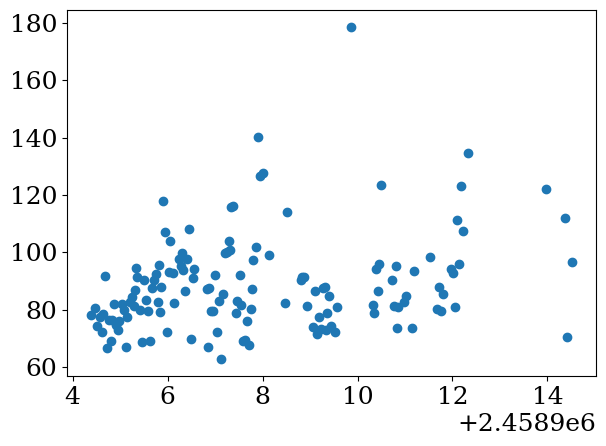

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.coordinates import SkyCoord
from astropy.time import Time
import astropy.units as u
from astropy import wcs
from astropy.utils.data import download_file
from astropy.io import fits


plt.rcParams.update({
    "font.size": 18,
    "font.family": "serif",
    "figure.autolayout": True,
    "axes.grid": False,
    # "xtick.minor.visible": True,
    # "ytick.minor.visible": True,
})

timeOffset = 2400000.5

sector = 22
cam = 1
ccd = 3
cut = 8


interpedPos = pd.read_csv(f"./InterpolatedQuerryResult_{sector}_{cam}_{ccd}_{cut}.csv")

name = " Lincoln "

interpedNamePosIDs = interpedPos.index[interpedPos["Name"] == name]
interpedNamePos = interpedPos.loc[interpedNamePosIDs]


matchedNamePos = pd.read_csv(f"./{name}Matches.csv")

plt.scatter(matchedNamePos["Time"], matchedNamePos["flux"])

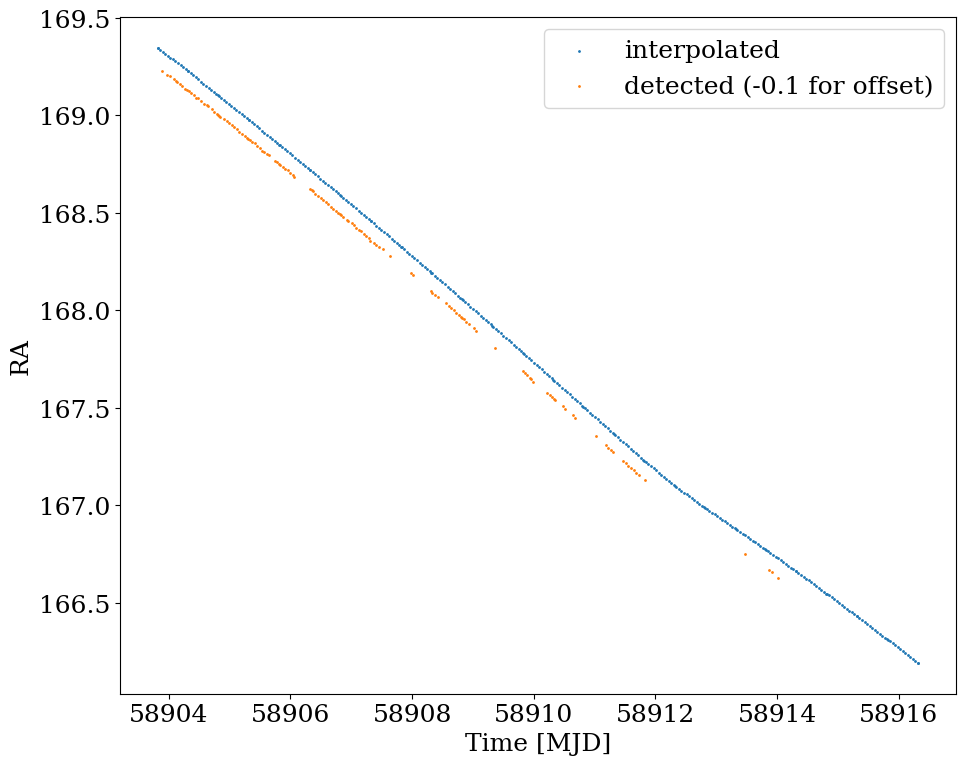

In [16]:
fig, ax = plt.subplots(1,1,figsize = (10,8))

ax.set_xlabel("Time [MJD]")
ax.set_ylabel("RA")

ax.scatter(interpedNamePos["epoch"]-timeOffset,interpedNamePos["RA"], s=1, label="interpolated")
ax.scatter(matchedNamePos["Time"]-timeOffset, matchedNamePos["RA"]-0.1, s=1, label="detected (-0.1 for offset)") # -0.2 ofset just to see better. interp is so good that itstoo hard to see
ax.legend()

In [17]:
allFluxes = np.load(f"../OzData/sector{sector}_cam{cam}_ccd{ccd}_cut{cut}_of16_ReducedFlux.npy")

# /home/users/ble61/Documents/ASTR480/OzData/sector29_cam1_ccd3_cut7_of16_ReducedFlux.npy

numFrames = allFluxes.shape[0]
allFluxes.shape

(1246, 512, 512)

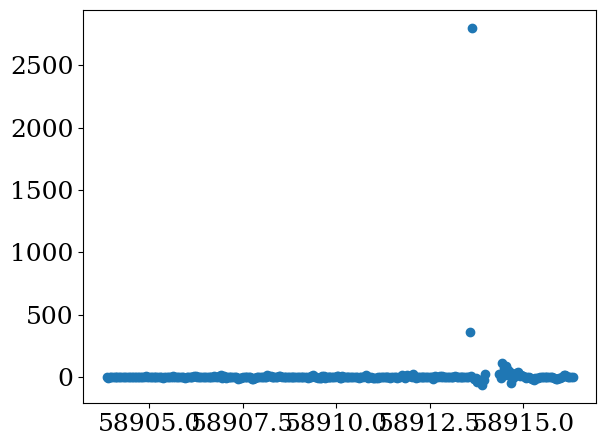

In [18]:
targetWSC = fits.open(f"../OzData/{sector}_{cam}_{ccd}_{cut}_wcs.fits")[0]

w = wcs.WCS(targetWSC.header)

interpCoords=SkyCoord(ra = interpedNamePos["RA"], dec = interpedNamePos["Dec"], unit="deg")

interpedX, interpedY  = w.all_world2pix(interpCoords.ra, interpCoords.dec,0)

interpedX = interpedX.round().astype(int)
interpedY = interpedY.round().astype(int)


startTime = targetWSC.header["MJD-OBS"]
endTime = targetWSC.header["MJD-END"]

frameTimes = np.linspace(startTime,endTime,numFrames)

frameNums = [ np.argmin(np.abs(frameTimes-(time-timeOffset))) for time in interpedNamePos["epoch"]] #2400000.5 is ofset between JD and MJD

interpedNamePos["epoch"].max() - interpedNamePos["epoch"].min()


fUnq, fUnqId = np.unique(frameNums, return_index=True)

# theseFluxes = allFluxes[fUnq,xUnq.round().astype(int),yUnq.round().astype(int)]

# assert np.array_equal()
xs = interpedX[fUnqId]
ys = interpedY[fUnqId]

fluxShape = allFluxes.shape

mask = (fUnq < fluxShape[0]) & (xs < fluxShape[1]) & (ys<fluxShape[2])

xsIn = xs[mask]
ysIn = ys[mask]
fsIn = fUnq[mask]

sumFluxes = []

for f,x,y in zip(fsIn, ysIn, xsIn): #????looks like x and y is flipped
    sumFluxes.append(np.sum(allFluxes[f,x-3:x+3,y-3:y+3]))




thisLC = allFluxes[fsIn,ysIn,xsIn] #????looks like x and y is flipped

plt.scatter(frameTimes[fsIn], sumFluxes)

255

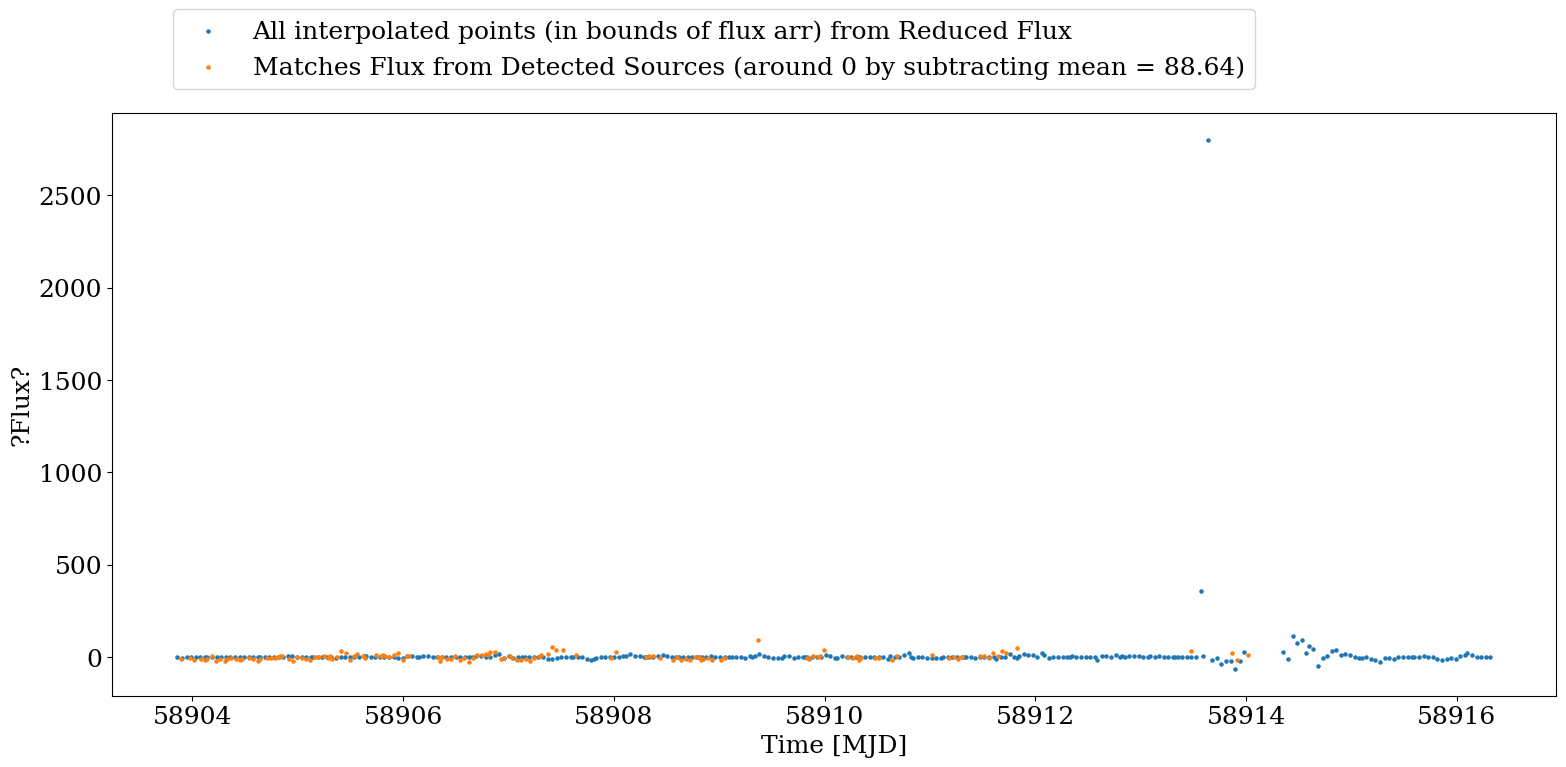

In [19]:
pSize = 5
fig, ax = plt.subplots(1,1,figsize=(16,8))
ax.set_xlabel("Time [MJD]")
ax.set_ylabel("?Flux?")

ax.scatter(frameTimes[fsIn], sumFluxes, s=pSize, label = "All interpolated points (in bounds of flux arr) from Reduced Flux ")

matchedMeanFlux = np.mean(matchedNamePos["flux"])

ax.scatter(matchedNamePos["Time"]-timeOffset, matchedNamePos["flux"]-matchedMeanFlux, s=pSize, label = f"Matches Flux from Detected Sources (around 0 by subtracting mean = {matchedMeanFlux.round(2)})")

# ax.scatter(matchedNamePos["Time"]-timeOffset, matchedNamePos["flux"], s=pSize, label = f"Matches Flux from Detected Sources (around 0 by subtracting mean = {matchedMeanFlux.round(2)})")

ax.legend(bbox_to_anchor=(0.8, 1.2))

np.argmax(sumFluxes)

-0.48594228966242436

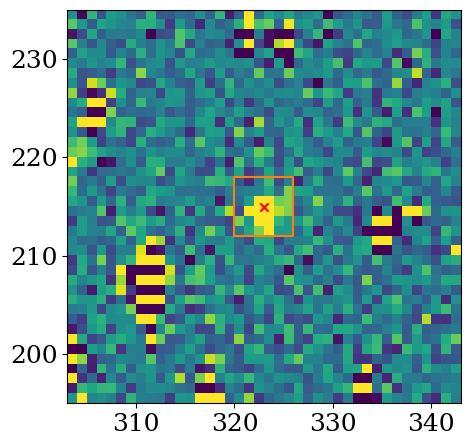

In [45]:
point = 160
numPx = 20

#????looks like x and y is flipped

x = ysIn[point]
y = xsIn[point]

fig, ax = plt.subplots()

toShow = allFluxes[fsIn[point+13
                        ],x-numPx:x+numPx,y-numPx:y+numPx]

ax.imshow(toShow, extent = [x-numPx,x+numPx,y-numPx,y+numPx], vmin=np.percentile(toShow, 3), vmax=np.percentile(toShow,97))
ax.scatter(x,y, c="r", marker="x")

ax.plot([x-3,x+3,x+3,x-3,x-3],[y-3,y-3,y+3,y+3,y-3], c="tab:orange")


np.sum(allFluxes[fsIn[point],x-3:x+3,y-3:y+3])

-3.5455096777142945

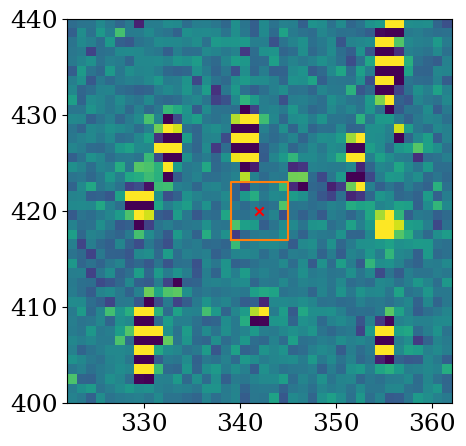

In [21]:

detectedPix = SkyCoord(matchedNamePos["RA"], matchedNamePos["Dec"], unit="deg" )

detcX, detcY = w.all_world2pix(detectedPix.ra, detectedPix.dec,0)


detcX = detcX.round().astype(int)
detcY = detcY.round().astype(int)

detcFrameNums = [ np.argmin(np.abs(frameTimes-(time))) for time in matchedNamePos["mjd"]]



point = 50
numPx = 20

#????looks like x and y is flipped

x = detcY[point]
y = detcX[point]

fig, ax = plt.subplots()

toShow = allFluxes[detcFrameNums[point],x-numPx:x+numPx,y-numPx:y+numPx]

ax.imshow(toShow, extent = [x-numPx,x+numPx,y-numPx,y+numPx], vmin=np.percentile(toShow, 3), vmax=np.percentile(toShow,97))
ax.scatter(x,y, c="r", marker="x")

ax.plot([x-3,x+3,x+3,x-3,x-3],[y-3,y-3,y+3,y+3,y-3], c="tab:orange")


np.sum(allFluxes[fsIn[point],x-3:x+3,y-3:y+3])
